In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %pip uninstall Pearl -y
# %rm -rf Pearl
# !git clone https://github.com/facebookresearch/Pearl.git
# %cd Pearl
# %pip install .
# %cd ..

In [3]:
import os
os.chdir('D:\Git-projects\Pearl')
os.getcwd()

'd:\\Git-projects\\Pearl'

In [4]:
import torch

if torch.cuda.is_available():
    print("Processing in GPU")
else:
    print("Processing in CPU")

Processing in GPU


In [6]:
# %rm -rf pearl_neurips_demo
# !git clone https://github.com/PearlAgent/pearl_neurips_demo.git

In [7]:
from pearl.neural_networks.sequential_decision_making.q_value_networks import EnsembleQValueNetwork
from pearl.replay_buffers.sequential_decision_making.bootstrap_replay_buffer import BootstrapReplayBuffer
from pearl.policy_learners.sequential_decision_making.bootstrapped_dqn import BootstrappedDQN
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.action_representation_modules.identity_action_representation_module import IdentityActionRepresentationModule
from pearl.history_summarization_modules.lstm_history_summarization_module import LSTMHistorySummarizationModule
from pearl.policy_learners.sequential_decision_making.deep_q_learning import DeepQLearning
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl_neurips_demo.env_model import SequenceClassificationModel
from pearl_neurips_demo.env import RecEnv
import torch
import matplotlib.pyplot as plt
import numpy as np

set_seed(0)

In [8]:
if torch.cuda.is_available():
    print("Processing in GPU")
else:
    print("Processing in CPU")

Processing in GPU


In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [10]:
# load environment
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SequenceClassificationModel(100).to(device)
model.load_state_dict(torch.load("pearl_neurips_demo/env_model_state_dict.pt"))
actions = torch.load("pearl_neurips_demo/news_embedding_small.pt")
env = RecEnv(list(actions.values())[:100], model)
observation, action_space = env.reset()

In [11]:
# create a pearl agent

action_representation_module = IdentityActionRepresentationModule(
    max_number_actions=action_space.n,
    representation_dim=action_space.action_dim,
)

# DQN-vanilla
agent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=1,
        action_space=action_space,
        hidden_dims=[64, 64],
        training_rounds=1,
        action_representation_module=action_representation_module,
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)

episode 50, step 1000, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 0.0
episode 100, step 2000, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 0.0
episode 150, step 3000, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 1.0
episode 200, step 4000, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 2.0
episode 250, step 5000, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 3.0
episode 300, step 6000, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 0.0
episode 350

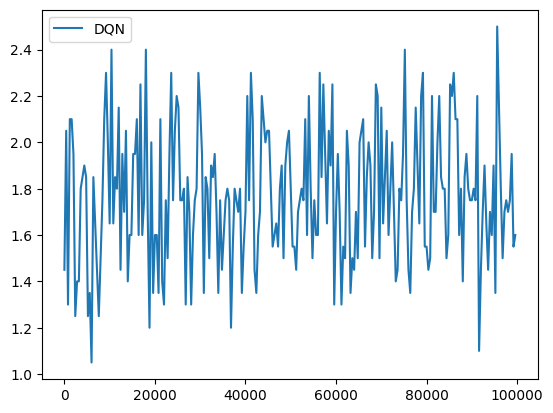

In [12]:
# experiment code
number_of_steps = 100000
record_period = 400

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=1000,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "DQN-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="DQN")
plt.legend()
plt.show()

episode 50, step 1000, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 1.0
episode 100, step 2000, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 2.0
episode 150, step 3000, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 1.0
episode 200, step 4000, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x000

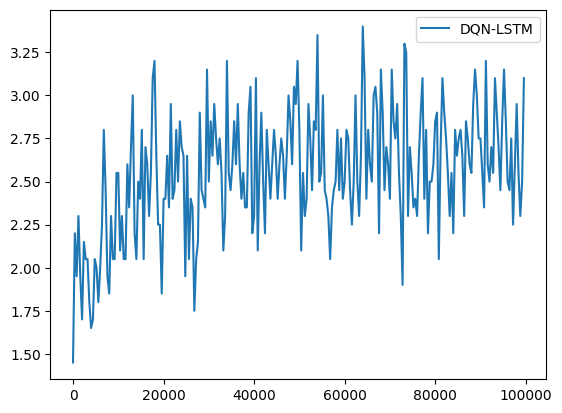

In [13]:
# Add a LSTM history summarization module

agent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=128,
        action_space=action_space,
        hidden_dims=[64, 64],
        training_rounds=5,
        action_representation_module=action_representation_module,
    ),
    history_summarization_module=LSTMHistorySummarizationModule(
        observation_dim=1,
        action_dim=100,
        hidden_dim=128,
        history_length=8,
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=1000,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "DQN-LSTM-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="DQN-LSTM")
plt.legend()
plt.show()

episode 5, step 100, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 2.0
episode 10, step 200, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 1.0
episode 15, step 300, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
return: 3.0
episode 20, step 400, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=<pearl_neurips_demo.env.RecEnv object at 0x00000226BB6C0CA0>
r

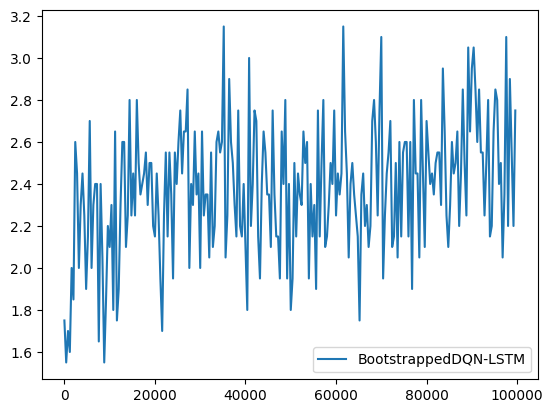

In [14]:
# Better exploration with BootstrappedDQN-LSTM

agent = PearlAgent(
    policy_learner=BootstrappedDQN(
        q_ensemble_network=EnsembleQValueNetwork(
            state_dim=128,
            action_dim=100,
            ensemble_size=10,
            output_dim=1,
            hidden_dims=[64, 64],
            prior_scale=0.3,
        ),
        action_space=action_space,
        training_rounds=50,
        action_representation_module=action_representation_module,
    ),
    history_summarization_module=LSTMHistorySummarizationModule(
        observation_dim=1,
        action_dim=100,
        hidden_dim=128,
        history_length=8,
    ),
    replay_buffer=BootstrapReplayBuffer(100_000, 1.0, 10),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "BootstrappedDQN-LSTM-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="BootstrappedDQN-LSTM")
plt.legend()
plt.show()